# PROJECT 2

**Hypothesis:**
- to show the positive correlation between Sea Surface Temperature (SST) and Ocean Net Primary Production in the North Atlantic coastal water column.

In [17]:
import json
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from cycler import cycler
import hvplot.pandas
import lxml.html


**Data:**
- CSV Data set is a High Performance Liquid Chromatography (HPLC) pigment monthly analysis of chlorophyll-a concentration (mg/L) from rosette bottle samples at various depths from the E.U. Copernicus Marine Service Information data base, 2020-2021, 47N-342W.
- API data set is the monthly Sea Surface Temperature (°C) on coordinates 47N-342W, 2020-2021, sourced at E.U. Copernicus Marine Service Information data base.

In [18]:

__author__     = "Copernicus Marine User Support Team"
__copyright__  = "(C) 2021 E.U. Copernicus Marine Service Information"
__credits__    = ["E.U. Copernicus Marine Service Information"]
__license__    = "MIT License - You must cite this source"
__version__    = "202104"
__maintainer__ = "D. Bazin, E. DiMedio, C. Giordan"
__email__      = "servicedesk dot cmems at mercator hyphen ocean dot eu"


def copernicus_marine_login(url, user, pwd):
    """
    Open a connection to Copernicus Marine CAS with user credentials.

    Parameters
    ----------
    username : str
        Copernicus Marine Username, provided for free from https://marine.copernicus.eu .
    password : str
        Copernicus Marine Password, provided for free from https://marine.copernicus.eu .

    Returns
    -------
    bool
        Returns ``conn_session`` if credentials are correct, ``False`` otherwise.

    """
    params = {'service': url}
    cmems_cas_url = 'https://cmems-cas.cls.fr/cas/login'
    conn_session = requests.session()
    login_session = conn_session.get(cmems_cas_url, params=params)
    login_from_html = lxml.html.fromstring(login_session.text)
    hidden_elements_from_html = login_from_html.xpath(
        '//form//input[@type="hidden"]')
    payload = {
        he.attrib['name']: he.attrib['value']
        for he in hidden_elements_from_html
        }
    payload['username'] = user
    payload['password'] = pwd
    conn_session.post(cmems_cas_url, data=payload, params=params)
    return conn_session

def get_data(url, output_filename, conn_session, csv=False):
    if 'productdownload' in url:
        url = f'{url}&mode=console'
        if csv:
            postprocess = True
    else:
        postprocess = False
    req = conn_session.get(url, stream=True)
    with open(output_filename,'wb') as of:
        for chunk in req.iter_content(chunk_size=1000000):
            of.write(chunk)
    if postprocess:
        try:
            from cmemsapi import cmemsapi as cmust
        except:
            print('Please install cmust if you want to convert to .csv by issuing in your terminal:\npip install cmemsapi')
            raise SystemExit
        cmust.to_csv(output_filename, output_filename)
    return True


conn_session = copernicus_marine_login('https://nrt.cmems-du.eu/motu-web/Motu?action=productdownload&service=MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012-TDS&product=dataset-armor-3d-rep-monthly&variable=sea_water_temperature&t_lo=2020-11-15+12:00:00&t_hi=2021-11-15+12:00:00&x_lo=-377.000&x_hi=-377.000&y_lo=47.566&y_hi=47.566', 'ahulse', 'Monty100')
get_data('https://nrt.cmems-du.eu/motu-web/Motu?action=productdownload&service=MULTIOBS_GLO_PHY_TSUV_3D_MYNRT_015_012-TDS&product=dataset-armor-3d-rep-monthly&variable=sea_water_temperature&t_lo=2020-11-15+12:00:00&t_hi=2021-11-15+12:00:00&x_lo=-377.000&x_hi=-377.000&y_lo=47.566&y_hi=47.566', 'sea_surface_water_temperature.nc', conn_session, csv=True)


[INFO] CONVERTING TO CSV
[INFO] ------------------
[INFO-CSV] Output file : sea_surface_water_temperature.csv
[INFO-CSV] File format : Comma-Separated Values
[INFO-CSV] Preview Stat:
        depth  latitude  longitude         to
count   13.0    13.000     13.000  13.000000
mean     0.0    47.625    342.875  14.471076
std      0.0     0.000      0.000   2.083826
min      0.0    47.625    342.875  12.079000
25%      0.0    47.625    342.875  12.598999
50%      0.0    47.625    342.875  13.636999
75%      0.0    47.625    342.875  16.584000
max      0.0    47.625    342.875  17.802000
[INFO] ------------------


True

**Data Cleaning:**

In [19]:
chl_data = pd.read_csv("chl-a conc.csv")

chl_data.drop(index=(range(13, 26)), inplace=True, errors='raise')
chl_data.rename(columns={'time': 'Date', 'chl':'chl-a (μg/L)'}, inplace=True, errors='raise')

chl_data['Date'] = chl_data['Date'].apply(lambda x : str(x))
chl_data['Date'] = chl_data['Date'].apply(lambda x: x.split('T')[0])
chl_data['Date'] = chl_data['Date'].replace(['2020-11-16', '2020-12-16', '2021-01-16', '2021-03-16', '2021-04-16', '2021-05-16', '2021-06-16', '2021-07-16', '2021-08-16', '2021-09-16', '2021-10-16', '2021-11-16'], ['2020-11-15', '2020-12-15', '2021-01-15', '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15', '2021-07-15', '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15'])
chl_data.round({'chl-a (μg/L)': 2})

,Date,chl-a (μg/L)
0,2020-11-15,0.25
1,2020-12-15,0.31
2,2021-01-15,0.34
3,2021-02-15,0.35
4,2021-03-15,0.55
5,2021-04-15,0.45
6,2021-05-15,0.36
7,2021-06-15,0.34
8,2021-07-15,0.28
9,2021-08-15,0.24


In [20]:
sst_data = pd.read_csv("sst.csv")

sst_data.drop(columns=['depth', 'latitude', 'longitude'], inplace=True, errors='raise')
sst_data.rename(columns={'time': 'Date', 'to':'Temperature (°C)'}, inplace=True, errors='raise')
sst_data

sst_data['Date'] = sst_data['Date'].apply(lambda x : str(x))
sst_data['Date'] = sst_data['Date'].apply(lambda x: x.split(' ')[0])
sst_data.round({'Temperature (°C)': 1})

,Date,Temperature (°C)
0,2020-11-15,13.6
1,2020-12-15,13.1
2,2021-01-15,12.5
3,2021-02-15,12.3
4,2021-03-15,12.1
5,2021-04-15,12.6
6,2021-05-15,13.4
7,2021-06-15,14.4
8,2021-07-15,16.6
9,2021-08-15,17.4


**Data Manipulation:**

In [21]:
data_merged = chl_data.merge(sst_data, on='Date', how='right')
data_merged.round({'chl-a (μg/L)': 2, 'Temperature (°C)': 1})

,Date,chl-a (μg/L),Temperature (°C)
0,2020-11-15,0.25,13.6
1,2020-12-15,0.31,13.1
2,2021-01-15,0.34,12.5
3,2021-02-15,0.35,12.3
4,2021-03-15,0.55,12.1
5,2021-04-15,0.45,12.6
6,2021-05-15,0.36,13.4
7,2021-06-15,0.34,14.4
8,2021-07-15,0.28,16.6
9,2021-08-15,0.24,17.4


In [12]:
#coefficient of correleation (R)


**Data Visualisation:**

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2020-November'),
  Text(1, 0, 'December'),
  Text(2, 0, '2021-January'),
  Text(3, 0, 'Febuary'),
  Text(4, 0, 'March'),
  Text(5, 0, 'April'),
  Text(6, 0, 'May'),
  Text(7, 0, 'June'),
  Text(8, 0, 'July'),
  Text(9, 0, 'August'),
  Text(10, 0, 'September'),
  Text(11, 0, 'October'),
  Text(12, 0, 'November')])

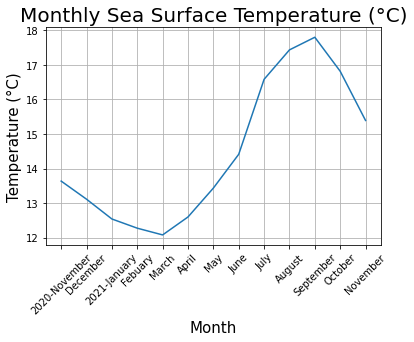

In [61]:
#data for plot 1:
sst_data['Date'] = sst_data['Date'].replace(['2020-11-15', '2020-12-15', '2021-01-15', '2021-02-15', '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15', '2021-07-15', '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15'], ['2020-November', 'December', '2021-January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])

sns.lineplot(data=sst_data, x="Date", y="Temperature (°C)", errorbar=None, estimator=sum); 
plt.ylabel("Temperature (°C)", fontsize=15);
plt.xlabel("Month", fontsize=15);
plt.title("Monthly Sea Surface Temperature (°C)", fontsize = 20); 
plt.grid('on')
plt.xticks(rotation=45)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12],
 [Text(0, 0, '2020-November'),
  Text(1, 0, 'December'),
  Text(2, 0, '2021-January'),
  Text(3, 0, 'Febuary'),
  Text(4, 0, 'March'),
  Text(5, 0, 'April'),
  Text(6, 0, 'May'),
  Text(7, 0, 'June'),
  Text(8, 0, 'July'),
  Text(9, 0, 'August'),
  Text(10, 0, 'September'),
  Text(11, 0, 'October'),
  Text(12, 0, 'November')])

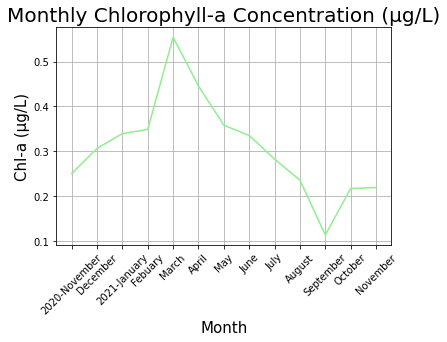

In [54]:
#data for plot 2:
chl_data['Date'] = chl_data['Date'].replace(['2020-11-15', '2020-12-15', '2021-01-15', '2021-02-15', '2021-03-15', '2021-04-15', '2021-05-15', '2021-06-15', '2021-07-15', '2021-08-15', '2021-09-15', '2021-10-15', '2021-11-15'], ['2020-November', 'December', '2021-January', 'Febuary', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November'])

sns.lineplot(data=chl_data, x="Date", y="chl-a (μg/L)", errorbar=None, estimator=sum, color='lightgreen'); 
plt.ylabel("Chl-a (μg/L)", fontsize=15); 
plt.xlabel("Month", fontsize=15); 
plt.title("Monthly Chlorophyll-a Concentration (μg/L)", fontsize = 20); 
plt.grid('on')
plt.xticks(rotation=45)

In [75]:
plot1 = chl_data.hvplot(x='Date', y='chl-a (μg/L)', width=575, color='lightgreen')
plot2 = sst_data.hvplot(x='Date', y='Temperature (°C)', width=575)
plot1.opts(xrotation=45)
plot2.opts(xrotation=45)
plot1 + plot2

:Layout
   .Curve.I  :Curve   [Date]   (chl-a (μg/L))
   .Curve.II :Curve   [Date]   (Temperature (°C))

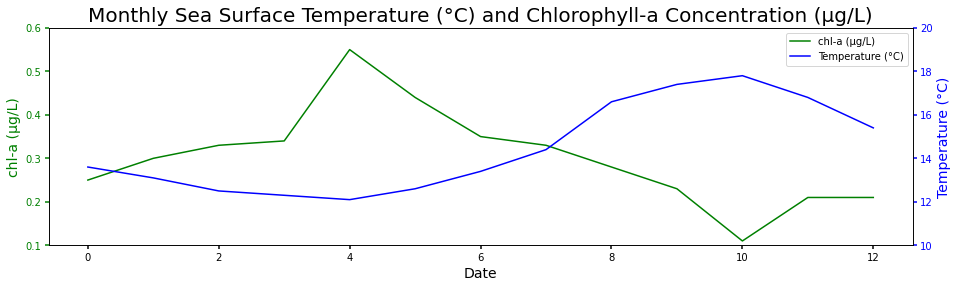

In [185]:
fig, ax = plt.subplots()
fig.subplots_adjust(right=2.8, left=0.8)

twin1 = ax.twinx()

p1, = ax.plot([0.25, 0.30, 0.33, 0.34, 0.55, 0.44, 0.35, 0.33, 0.28, 0.23, 0.11, 0.21, 0.21], "green", label="chl-a (μg/L)")
p2, = twin1.plot([13.6, 13.1, 12.5, 12.3, 12.1, 12.6, 13.4, 14.4, 16.6, 17.4, 17.8, 16.8, 15.4], "blue", label="Temperature (°C)")

ax.set_ylim(0.10, 0.60)
twin1.set_ylim(10.0, 20.0)

ax.set_xlabel("Date", fontsize = 14)
ax.set_ylabel("chl-a (μg/L)", fontsize = 14)
twin1.set_ylabel("Temperature (°C)", fontsize = 14)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

tkw = dict(size=4, width=1.5)
ax.tick_params(axis='y', colors=p1.get_color(), **tkw)
twin1.tick_params(axis='y', colors=p2.get_color(), **tkw)
ax.tick_params(axis='x', **tkw)

plt.title("Monthly Sea Surface Temperature (°C) and Chlorophyll-a Concentration (μg/L)", fontsize = 20); 

ax.legend(handles=[p1, p2])
plt.show()